In [5]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import peak_signal_noise_ratio

from stego import config
from stego.core import blocking
from stego.core.utils import dwt_rgb_forward
from stego.scripts.detail_comparison import compress_and_compare



In [6]:
IMG_PATH = str(Path(config.get_images_dir()) / "img_2448x2448_3x8bit_SRC_RGB_billiard_balls_b.png")

def show_image(img):
    plt.imshow(img)
    plt.show()
    
def compress_image(img, quality=90):
    encode_param = [cv2.IMWRITE_JPEG_QUALITY, quality]
    _, encoded_data = cv2.imencode('.jpg', img, encode_param)
    return cv2.imdecode(encoded_data, cv2.IMREAD_COLOR)

In [7]:
original_image = cv2.cvtColor(cv2.imread(IMG_PATH, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

In [8]:
encoded_image = compress_image(original_image, 90)


In [9]:

params = dict(level=4, wavelet='haar')
channels = cv2.split(original_image)

original_image_rgb_dwt = dwt_rgb_forward(original_image, **params)

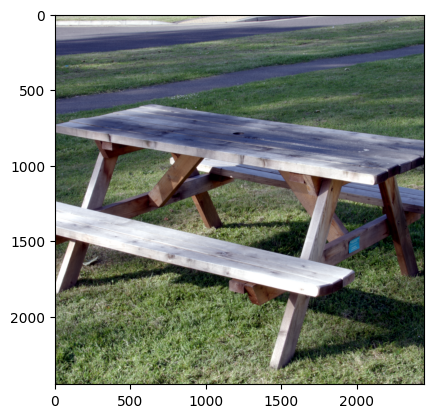

In [12]:


img_path = IMG_PATH = str(Path(config.get_images_dir()) / "img_2448x2448_3x8bit_SRC_RGB_garden_table.png")

conversions = {
    cv2.COLOR_BGR2RGB: ("R", "G", "B"),
    cv2.COLOR_BGR2YCrCb: ("Y", "Cr", "Cb"),
    cv2.COLOR_BGR2HSV: ("H", "S", "V"),
}

conversion = cv2.COLOR_BGR2RGB

img_original = cv2.imread(img_path, cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
img_to_analyze = cv2.cvtColor(img_rgb, conversion)

plt.imshow(img_rgb)

def metric(original, compressed, data_range=255):
    block_size = 4
    
    diff = cv2.absdiff(original, compressed) / 255
    
    diff_blocks = blocking.divide_image(diff, block_size)
    
    mean_block_diff = np.mean(diff_blocks, axis=(1, 2))
    mean_block_threshold_90 = np.quantile(np.abs(mean_block_diff), 0.9)
    pixel_threshold_90 = np.quantile(np.abs(diff), 0.9)

    
    return {
        "psnr":peak_signal_noise_ratio(original, compressed, data_range=data_range),
        # "mse": mean_squared_error(original, compressed),
        # "abs_mean": np.mean(diff),
        # "mean_block_diff": mean_block_diff,
        "mean_block_threshold_90": mean_block_threshold_90,
        "pixel_threshold_90": pixel_threshold_90
    }


# qualities=list(range(40, 100, 20)) , max_level=5, wavelet='haar', metric=mean_diff
settings = {
    "qualities": range(50, 100, 15),
    "max_level": 6,
    "wavelet": 'haar',
    "metric": metric,
    "channels": conversions[conversion]
}

data = compress_and_compare(img_to_analyze, **settings)


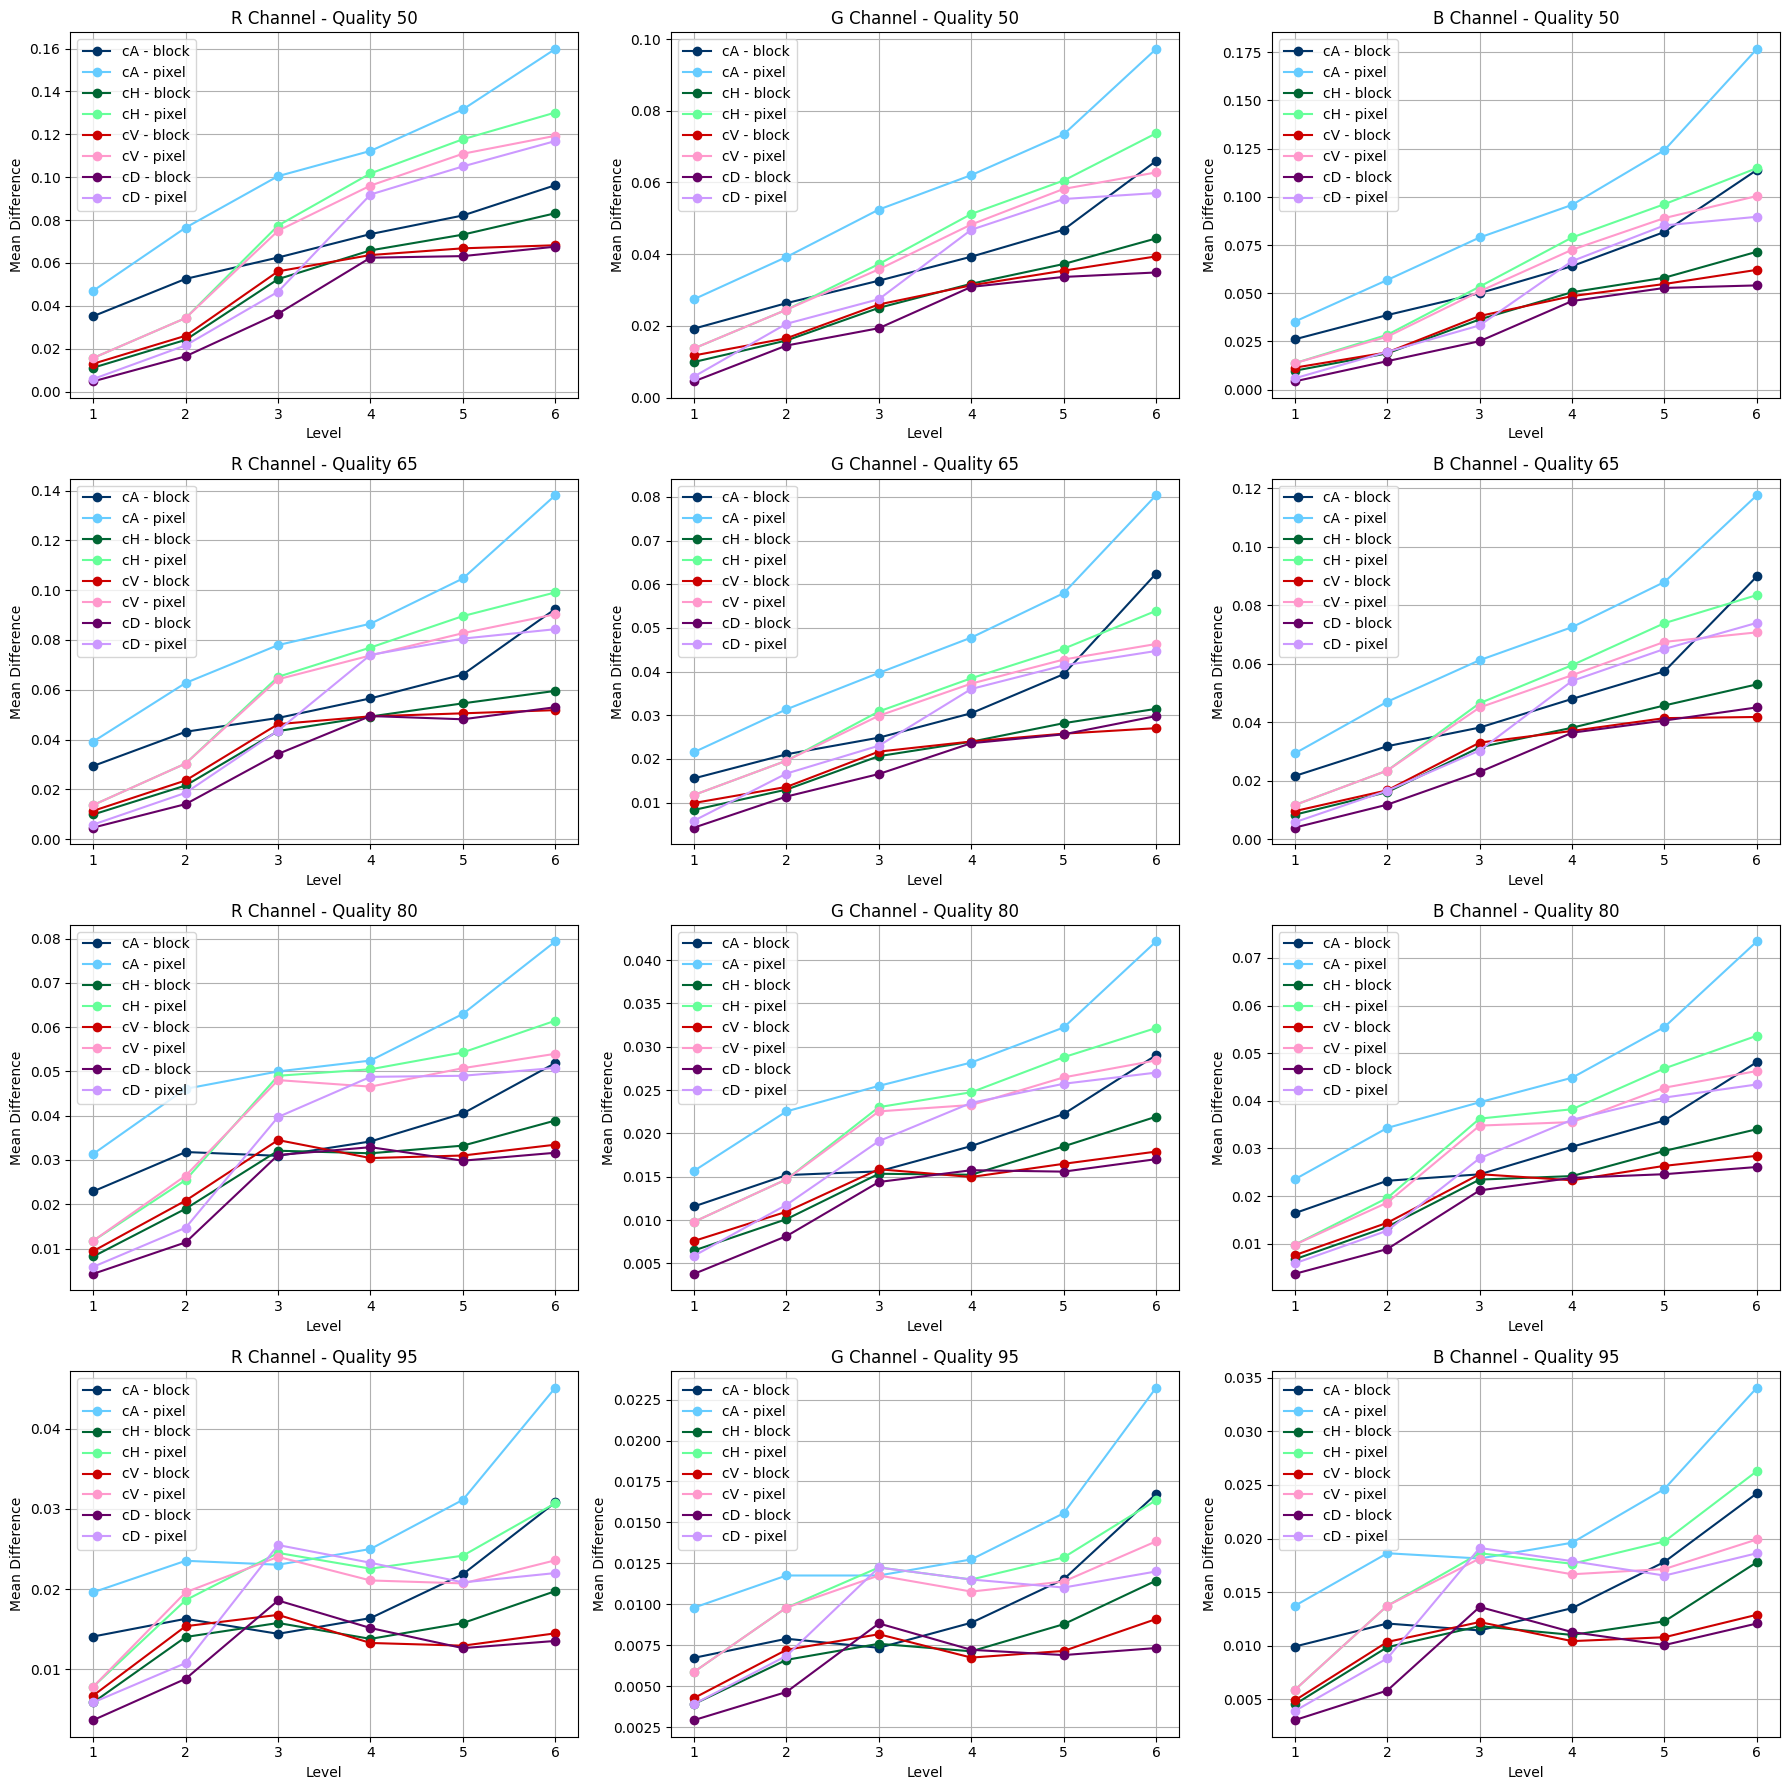

In [14]:

quality_levels = data.keys()
levels = range(1, settings["max_level"]+1)
color_pallet = [('#003366', '#66ccff'),
 ('#006633', '#66ff99'),
 ('#cc0000', '#ff99cc'),
 ('#660066', '#cc99ff')]

# Create a grid of plots
fig, axes = plt.subplots(nrows=len(quality_levels), ncols=3, figsize=(18, 18))

# Plot data for each channel
for i, quality in enumerate(quality_levels):
    channels = data[quality].keys()
    for j, channel in enumerate(channels):
        ax = axes[i, j]
        
        # Extract and plot data for each coefficient
        for coef, color in zip(['cA', 'cH', 'cV', 'cD'], color_pallet):
            
            plot_data1 = [data[quality][channel][f"l{level}"][coef]["mean_block_threshold_90"] for level in levels]
            plot_data2 = [data[quality][channel][f"l{level}"][coef]["pixel_threshold_90"] for level in levels]            
            ax.plot(levels, plot_data1, marker='o', label=f"{coef} - block", color=color[0])
            ax.plot(levels, plot_data2, marker='o', label=f"{coef} - pixel", color=color[1])
            
        
        ax.set_title(f"{channel} Channel - Quality {quality}")
        ax.set_xlabel("Level")
        ax.set_ylabel("Mean Difference")
        ax.legend()
        ax.grid(True)
plt.tight_layout()
plt.show()